In [31]:
!pip install nltk seaborn

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import re
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [1]:
try:
    df = pd.read_csv('/content/spa.txt', sep='\t', header=None)
    df.columns = ['english', 'spanish', 'attribution'][:len(df.columns)]
    display(df.head())
    print(f'Total pairs loaded: {len(df)}')
except Exception as e:
    print(f'Error loading file: {e}')

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


Total pairs loaded: 118964


In [2]:
if 'df' in locals():
    display(df.info())
else:
    print('DataFrame not defined due to loading error.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118964 entries, 0 to 118963
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  118964 non-null  object
 1   spanish  118964 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


None

In [4]:
def normalize(text):
    text = text.lower().strip()
    text = re.sub(r"[^a-zA-Z¿¡?.!,]+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text

In [5]:
df["english"] = df["english"].apply(normalize)
df["spanish"] = df["spanish"].apply(normalize)
df["spanish"] = df["spanish"].apply(lambda x: "<sos> " + x + " <eos>")

In [6]:
def tokenize(text):
    return text.split()

In [7]:
def build_vocab(sentences, min_freq=2):
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenize(sentence))

    vocab = {
        "<pad>": 0,
        "<sos>": 1,
        "<eos>": 2,
        "<unk>": 3
    }

    idx = 4
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1

    return vocab

In [8]:
src_vocab = build_vocab(df["english"])
trg_vocab = build_vocab(df["spanish"])

print("Src vocab size:", len(src_vocab))
print("Trg vocab size:", len(trg_vocab))

Src vocab size: 14012
Trg vocab size: 19763


In [9]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [10]:
class TranslationDataset(Dataset):
    def __init__(self, dataframe, src_vocab, trg_vocab):
        self.data = dataframe
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.data)

    def numericalize(self, sentence, vocab):
        return [
            vocab[token] if token in vocab else vocab["<unk>"]
            for token in tokenize(sentence)
        ]

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        src = self.numericalize(row["english"], self.src_vocab)
        trg = self.numericalize(row["spanish"], self.trg_vocab)
        return torch.tensor(src), torch.tensor(trg)

In [11]:
def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)

    src_batch = nn.utils.rnn.pad_sequence(
        src_batch,
        padding_value=src_vocab["<pad>"]
    )

    trg_batch = nn.utils.rnn.pad_sequence(
        trg_batch,
        padding_value=trg_vocab["<pad>"]
    )

    return src_batch, trg_batch

In [12]:
BATCH_SIZE = 64

train_dataset = TranslationDataset(train_df, src_vocab, trg_vocab)
test_dataset = TranslationDataset(test_df, src_vocab, trg_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_fn)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, collate_fn=collate_fn)

# LSTM Encoder-Decoder without Attention

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim)
        self.fc = nn.Linear(hid_dim, output_dim)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(0))
        return prediction, hidden, cell

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(trg_len, batch_size, vocab_size).to(self.device)

        hidden, cell = self.encoder(src)
        input = trg[0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1

        return outputs

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EMB_DIM = 256
HID_DIM = 512

src_vocab_size = max(src_vocab.values()) + 1
trg_vocab_size = max(trg_vocab.values()) + 1

print("Correct src size:", src_vocab_size)
print("Correct trg size:", trg_vocab_size)

encoder = Encoder(src_vocab_size, EMB_DIM, HID_DIM)
decoder = Decoder(trg_vocab_size, EMB_DIM, HID_DIM)

model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

Correct src size: 14012
Correct trg size: 19765


In [17]:
def train(model, loader):
    model.train()
    total_loss = 0

    for src, trg in loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, trg)

        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [18]:
EPOCHS = 10

for epoch in range(EPOCHS):
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 5.1139
Epoch 2, Loss: 3.6440
Epoch 3, Loss: 2.8619
Epoch 4, Loss: 2.3098
Epoch 5, Loss: 1.9377
Epoch 6, Loss: 1.6453
Epoch 7, Loss: 1.4231
Epoch 8, Loss: 1.2605
Epoch 9, Loss: 1.1128
Epoch 10, Loss: 1.0077


In [19]:
def translate(model, sentence):
    model.eval()

    sentence = normalize(sentence)
    tokens = tokenize(sentence)

    src_idx = [src_vocab.get(t, src_vocab["<unk>"]) for t in tokens]
    src_tensor = torch.LongTensor(src_idx).unsqueeze(1).to(device)

    hidden, cell = model.encoder(src_tensor)

    trg_idx = [trg_vocab["<sos>"]]

    for _ in range(50):
        trg_tensor = torch.LongTensor([trg_idx[-1]]).to(device)
        output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred = output.argmax(1).item()
        trg_idx.append(pred)

        if pred == trg_vocab["<eos>"]:
            break

    inv_vocab = {v:k for k,v in trg_vocab.items()}
    return [inv_vocab[i] for i in trg_idx]

In [20]:
references = []
hypotheses = []

for i in range(500):
    src = test_df.iloc[i]["english"]
    trg = test_df.iloc[i]["spanish"]

    prediction = translate(model, src)[1:-1]
    reference = tokenize(trg)[1:-1]

    hypotheses.append(prediction)
    references.append([reference])

bleu = corpus_bleu(references, hypotheses)
print("BLEU Score:", bleu)

BLEU Score: 0.21265433765831582


# LSTM Encoder-Decoder with Attention (Bahdanau (Additive) Attention)

In [21]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell


In [22]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.W1 = nn.Linear(enc_dim, dec_dim)
        self.W2 = nn.Linear(dec_dim, dec_dim)
        self.V = nn.Linear(dec_dim, 1)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        hidden = hidden.repeat(src_len,1,1)
        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention = self.V(energy).squeeze(2)
        return torch.softmax(attention, dim=0)

In [23]:
class LuongAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.W = nn.Linear(dec_dim, enc_dim)

    def forward(self, hidden, encoder_outputs):
        hidden = self.W(hidden.squeeze(0))
        energy = torch.sum(encoder_outputs * hidden.unsqueeze(0), dim=2)
        return torch.softmax(energy, dim=0)

In [24]:
class AttentionDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_dim, dec_dim, attention):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        self.attention = attention
        self.lstm = nn.LSTM(enc_dim + emb_dim, dec_dim)
        self.fc = nn.Linear(dec_dim, output_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)

        attn = self.attention(hidden, encoder_outputs)
        attn = attn.unsqueeze(2)

        weighted = torch.sum(attn * encoder_outputs, dim=0).unsqueeze(0)

        lstm_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        prediction = self.fc(output.squeeze(0))
        return prediction, hidden, cell, attn

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(trg_len, batch_size, vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[0]

        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(
                input, hidden, cell, encoder_outputs
            )
            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

In [26]:
EMB_DIM = 256
HID_DIM = 512

encoder = Encoder(src_vocab_size, EMB_DIM, HID_DIM)
attention = BahdanauAttention(HID_DIM, HID_DIM)
decoder = AttentionDecoder(trg_vocab_size, EMB_DIM, HID_DIM, HID_DIM, attention)

model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [27]:
def train(model, loader):
    model.train()
    total_loss = 0

    for src, trg in loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, trg)

        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [28]:
EPOCHS = 10

for epoch in range(EPOCHS):
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 4.6419
Epoch 2, Loss: 3.0437
Epoch 3, Loss: 2.2990
Epoch 4, Loss: 1.8461
Epoch 5, Loss: 1.5505
Epoch 6, Loss: 1.3375
Epoch 7, Loss: 1.1709
Epoch 8, Loss: 1.0309
Epoch 9, Loss: 0.9270
Epoch 10, Loss: 0.8338


In [29]:
def translate(sentence):
    model.eval()
    sentence = normalize(sentence)
    tokens = tokenize(sentence)

    src_idx = [src_vocab.get(t,3) for t in tokens]
    src_tensor = torch.LongTensor(src_idx).unsqueeze(1).to(device)

    encoder_outputs, hidden, cell = model.encoder(src_tensor)

    trg_idx = [trg_vocab["<sos>"]]
    attentions = []

    for _ in range(50):
        trg_tensor = torch.LongTensor([trg_idx[-1]]).to(device)
        output, hidden, cell, attn = model.decoder(
            trg_tensor, hidden, cell, encoder_outputs
        )
        pred = output.argmax(1).item()
        trg_idx.append(pred)
        attentions.append(attn.squeeze().cpu().detach().numpy())

        if pred == trg_vocab["<eos>"]:
            break

    inv_vocab = {v:k for k,v in trg_vocab.items()}
    translation = [inv_vocab[i] for i in trg_idx]

    return translation, attentions

In [30]:
references = []
hypotheses = []

for i in range(300):
    src = test_df.iloc[i]["english"]
    trg = test_df.iloc[i]["spanish"]

    pred, _ = translate(src)
    pred = pred[1:-1]
    ref = tokenize(trg)[1:-1]

    hypotheses.append(pred)
    references.append([ref])

bleu = corpus_bleu(references, hypotheses)
print("BLEU Score:", bleu)

BLEU Score: 0.2671281799785577


In [33]:
def visualize_attention(src_sentence):
    translation, attentions = translate(src_sentence)

    src_tokens = tokenize(src_sentence)
    trg_tokens = translation[1:]

    attn_matrix = np.array(attentions)

    plt.figure(figsize=(10,8))
    sns.heatmap(attn_matrix,
                xticklabels=src_tokens,
                yticklabels=trg_tokens,
                cmap="Blues")
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.show()

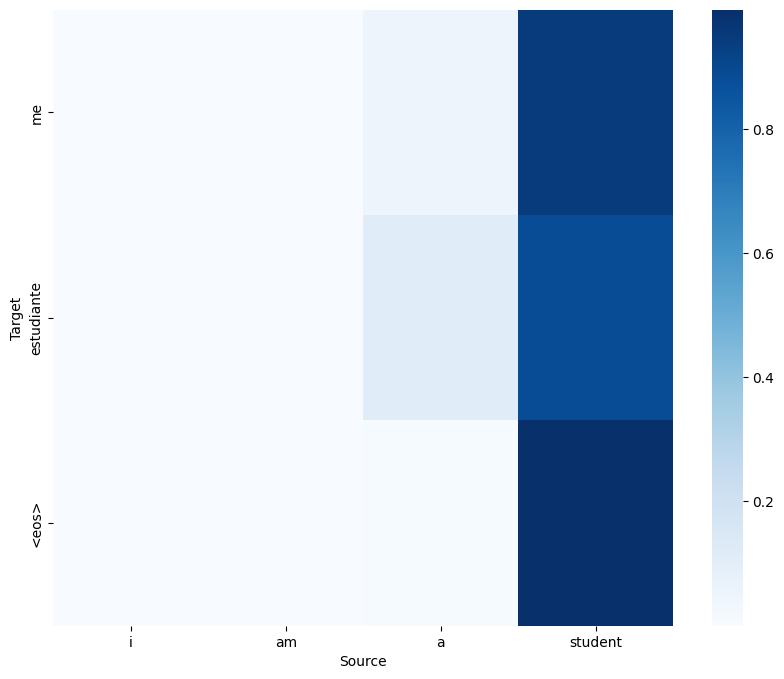

In [34]:
visualize_attention("i am a student")

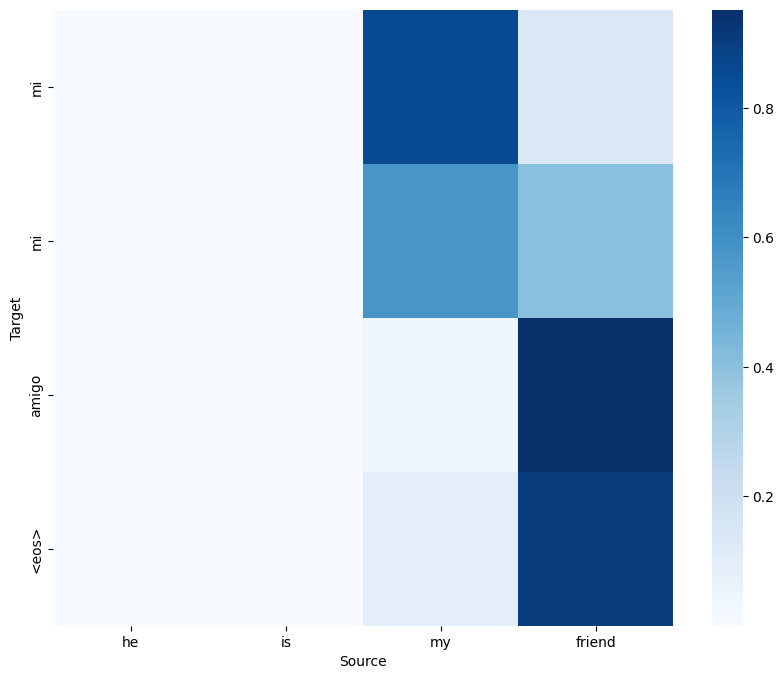

In [35]:
visualize_attention("he is my friend")

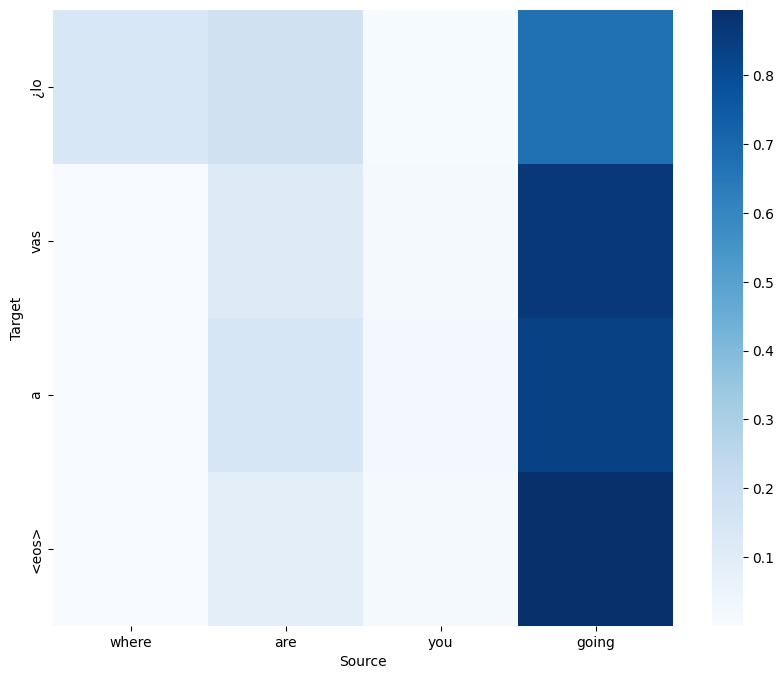

In [36]:
visualize_attention("where are you going")

# LSTM Encoder-Decoder with Attention (Luong (Multiplicative) Attention)

In [37]:
EMB_DIM = 256
HID_DIM = 512

encoder = Encoder(src_vocab_size, EMB_DIM, HID_DIM)
attention = LuongAttention(HID_DIM, HID_DIM)
decoder = AttentionDecoder(trg_vocab_size, EMB_DIM, HID_DIM, HID_DIM, attention)

model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [38]:
def train(model, loader):
    model.train()
    total_loss = 0

    for src, trg in loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, trg)

        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 4.9287
Epoch 2, Loss: 3.5364
Epoch 3, Loss: 2.8450


In [ ]:
def translate(sentence):
    model.eval()
    sentence = normalize(sentence)
    tokens = tokenize(sentence)

    src_idx = [src_vocab.get(t,3) for t in tokens]
    src_tensor = torch.LongTensor(src_idx).unsqueeze(1).to(device)

    encoder_outputs, hidden, cell = model.encoder(src_tensor)

    trg_idx = [trg_vocab["<sos>"]]
    attentions = []

    for _ in range(50):
        trg_tensor = torch.LongTensor([trg_idx[-1]]).to(device)
        output, hidden, cell, attn = model.decoder(
            trg_tensor, hidden, cell, encoder_outputs
        )
        pred = output.argmax(1).item()
        trg_idx.append(pred)
        attentions.append(attn.squeeze().cpu().detach().numpy())

        if pred == trg_vocab["<eos>"]:
            break

    inv_vocab = {v:k for k,v in trg_vocab.items()}
    translation = [inv_vocab[i] for i in trg_idx]

    return translation, attentions

In [ ]:
references = []
hypotheses = []

for i in range(300):
    src = test_df.iloc[i]["english"]
    trg = test_df.iloc[i]["spanish"]

    pred, _ = translate(src)
    pred = pred[1:-1]
    ref = tokenize(trg)[1:-1]

    hypotheses.append(pred)
    references.append([ref])

bleu = corpus_bleu(references, hypotheses)
print("BLEU Score:", bleu)

In [ ]:
def visualize_attention(src_sentence):
    translation, attentions = translate(src_sentence)

    src_tokens = tokenize(src_sentence)
    trg_tokens = translation[1:]

    attn_matrix = np.array(attentions)

    plt.figure(figsize=(10,8))
    sns.heatmap(attn_matrix,
                xticklabels=src_tokens,
                yticklabels=trg_tokens,
                cmap="Blues")
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.show()

In [ ]:
visualize_attention("i am a student")

In [ ]:
visualize_attention("he is my friend")

In [ ]:
visualize_attention("where are you going")